In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 200,
})

import numpy as np
import torch

rng = np.random.default_rng()

# Convert data

## Loading data from Apr 5, 2023

Block 2


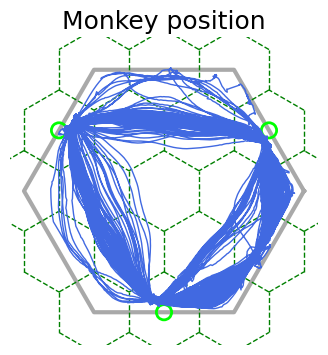

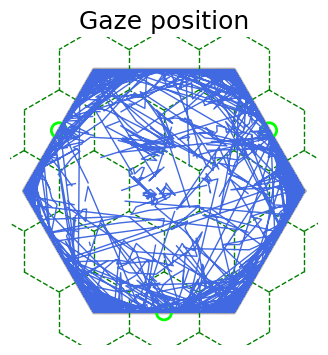

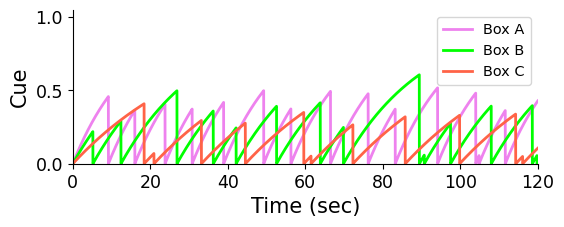

In [2]:
from hexarena.env import SimilarBoxForagingEnv
from hexarena.utils import load_monkey_data

filename = 'store/monkey-data_040523/testSession2.mat'
block_idx = rng.choice(7)
print('Block {}'.format(block_idx+1))
block_data = load_monkey_data(filename, block_idx)

assert len(np.unique(block_data['kappas']))==1
sigma = block_data['kappas'][0]
taus = block_data['taus']
env = SimilarBoxForagingEnv(
    box={
        '_target_': 'hexarena.box.StationaryBox', 'num_patches': 1, 'num_levels': 10, 'num_grades': 10,
        'sigma': sigma,
    },
    boxes=[{'tau': tau} for tau in taus],
)

_, ax = plt.subplots(figsize=(4, 4))
env.arena.plot_mesh(ax)
pos_xyz = block_data['pos_xyz']/1860.5
ax.plot(pos_xyz[:, 0], pos_xyz[:, 1], color='royalblue', linewidth=1)
ax.set_title('Monkey position')

_, ax = plt.subplots(figsize=(4, 4))
env.arena.plot_mesh(ax)
pos_xyz = block_data['gaze_xyz']/1860.5
ax.plot(pos_xyz[:, 0], pos_xyz[:, 1], color='royalblue', linewidth=1)
ax.set_title('Gaze position')

_, ax = plt.subplots(figsize=(6, 2))
colors = ['violet', 'lime', 'tomato']
for i, color in enumerate(colors):
    ax.plot(block_data['t'], block_data['cues'][:, i], color=color)
ax.legend(['Box A', 'Box B', 'Box C'], fontsize='x-small', loc='upper right')
ax.set_xlim([0, 120])
ax.set_xlabel('Time (sec)')
ax.set_ylim([0, 1.05])
ax.set_ylabel('Cue')

plt.show()

Discretizing in both time and space...
'observations': (1200, 5)
'actions': (1199,)
'rewards': (1199,)
Histogram of single time step move distance


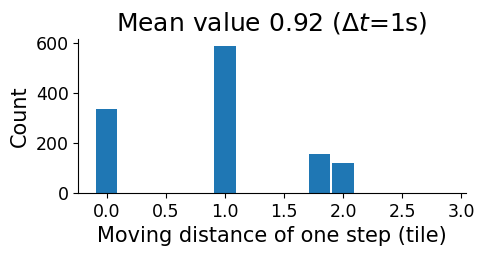

In [3]:
print("Discretizing in both time and space...")
env_data = env.convert_experiment_data(block_data)
observations, actions, rewards = env.extract_observation_action_reward(env_data)
print("'observations': {}".format(observations.shape))
print("'actions': {}".format(actions.shape))
print("'rewards': {}".format(rewards.shape))

ds = []
for i in range(len(actions)):
    x1, y1 = env.arena.anchors[observations[i+1, 0]]
    x0, y0 = env.arena.anchors[observations[i, 0]]
    ds.append(((x1-x0)**2+(y1-y0)**2)**0.5)
ds = np.array(ds)*env.arena.resol

print("Histogram of single time step move distance")
_, ax = plt.subplots(figsize=(5, 2))
ax.hist(ds, np.arange(-0.1, ds.max(), 0.2), rwidth=0.9)
ax.set_xlabel('Moving distance of one step (tile)')
ax.set_ylabel('Count')
ax.set_title('Mean value {:.2f}'.format(ds.mean())+' ($\Delta t$'+'={:g}s)'.format(env.dt))

plt.show()

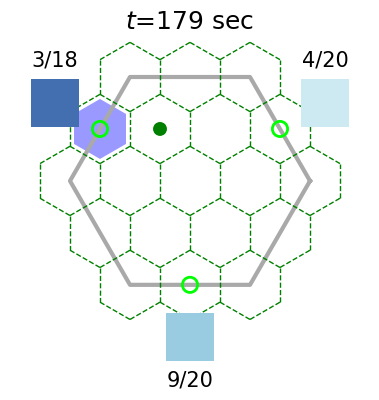

In [4]:
counts = np.zeros((len(env_data['pos']), 3, 2))
for t in range(len(env_data['push'])):
    if env_data['push'][t]:
        pos = env_data['pos'][t+1]
        if pos in env.arena.boxes:
            b_idx = env.arena.boxes.index(pos)
            counts[t, b_idx, 1] = 1
            if env_data['success'][t]:
                counts[t, b_idx, 0] = 1
counts = np.cumsum(counts, axis=0).astype(int)

fig, ani = env.play_episode(
    env_data['pos'], env_data['gaze'],
    rewarded=[None]+[*env_data['success']],
    colors=env_data['colors'], counts=counts,
    tmax=180,
)
ani.save('store/monkey-trial_block-{:d}.gif'.format(block_idx+1), fps=6)